# Data partition: training and testing

In Machine Learning, it is mandatory to have training and testing set. Some
 time a verification set is also recommended. Here are some functions 
 for splitting training/testing set in `sklearn`:

- `train_test_split`: create series of test/training partitions
- `Kfold` splits the data into k groups
- `StratifiedKFold` splits the data into k groups based on a grouping factor.
- `RepeatKfold`
- `LeaveOneOut`
- `LeavePOut`

We focus on `train_test_split`, `KFolds` and  `StratifiedKFold`.

We will use the airquality dataset to demonstrate:

## Dataset

In [1]:
import pandas as pd
df = pd.DataFrame(pd.read_csv('/zfs/citi/workshop_data/python_ml/r_airquality.csv'))
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [2]:
# need to deal w/ missing values
import numpy as np
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.00000,190.000000,7.4,67.0,5.0,1.0
1,36.00000,118.000000,8.0,72.0,5.0,2.0
2,12.00000,149.000000,12.6,74.0,5.0,3.0
3,18.00000,313.000000,11.5,62.0,5.0,4.0
4,42.12931,185.931507,14.3,56.0,5.0,5.0
...,...,...,...,...,...,...
148,30.00000,193.000000,6.9,70.0,9.0,26.0
149,42.12931,145.000000,13.2,77.0,9.0,27.0
150,14.00000,191.000000,14.3,75.0,9.0,28.0
151,18.00000,131.000000,8.0,76.0,9.0,29.0


In [3]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X.shape, y.shape

((153, 5), (153,))

## Train-test split
Here we use `train_test_split` to randomly split 60% data for training and the rest for testing:

![image](https://user-images.githubusercontent.com/43855029/114209883-22b81700-992d-11eb-83a4-c4ab1538a1e5.png)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.6,random_state=123)
X_train.shape, y_train.shape

((91, 5), (91,))

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()

model.fit(X_train, y_train) #Training the model, not running now
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"r^2 on the test set: {r2_score(y_test, y_pred): 0.2f}")

r^2 on the test set:  0.31


**Question**: What are some of the limitations with this approach?

## Cross validation
- CV is a resampling process used to evaluate ML model on limited data sample.
- The general procedure:
    - Shuffle data randomly
    - Split the data into **k** groups
    For each group:
        - Split into training & testing set
        - Fit a model on each group's training & testing set
        - Retain the evaluation score and summarize the skill of model


![image](https://user-images.githubusercontent.com/43855029/114211785-103edd00-992f-11eb-89d0-bbd7bd0c0178.png)

[Documentation on split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split)

**Question**: How does this procedure address some of the limitations with a simple train/test split?

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cv = KFold(n_splits=5, shuffle=True, random_state=20)

# initialize the model
model = LinearRegression()
r2s = []
for ix, (train_index, test_index) in enumerate(cv.split(X.values)):
    X_train = X.values[train_index]
    y_train = y.values[train_index]
    X_test = X.values[test_index]
    y_test = y.values[test_index]
    model.fit(X_train, y_train) #Training the model, not running now
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)
    print(f"r^2 for the fold no. {ix+1} on the test set: {r2_score(y_test, y_pred):0.2f}")
    
print(f"Mean r^2: {np.mean(r2s):0.2f}")
print(f"Std. dev. r^2: {np.std(r2s):0.2f}")

r^2 for the fold no. 1 on the test set: 0.62
r^2 for the fold no. 2 on the test set: 0.42
r^2 for the fold no. 3 on the test set: 0.49
r^2 for the fold no. 4 on the test set: 0.29
r^2 for the fold no. 5 on the test set: 0.38
Mean r^2: 0.44
Std. dev. r^2: 0.11


### Stratified k-fold CV
"Stratify" refers to sampling within a group to form the $k$ folds. For example, we may wish that the distribution of Ozone levels in the CV partitions looks similar to the distribution in the full dataset. This is especially important when we have class imbalance. 

<AxesSubplot:>

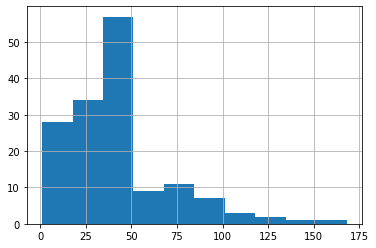

In [7]:
df.Ozone.hist()

It looks like we have a group of low-Ozone (<50) and high-Ozone (>=50) samples. Let's define a new variable indicating if the sample is low-ozone or high-ozone using this threshold: 

In [8]:
thresh = 50
df['high_ozone'] = df['Ozone']>=thresh
df.high_ozone.value_counts() / len(df)

False    0.771242
True     0.228758
Name: high_ozone, dtype: float64

Stratified k-fold will attempt to preserve the share of high/low ozone samples in each split. 

In [9]:
# let's first look at the distribution in each split w/out stratification
for ix, (train_index, test_index) in enumerate(cv.split(X.values)):
    y_train = y.values[train_index]
    print(pd.Series(y_train>thresh).value_counts()/len(y_train))

False    0.803279
True     0.196721
dtype: float64
False    0.778689
True     0.221311
dtype: float64
False    0.762295
True     0.237705
dtype: float64
False    0.788618
True     0.211382
dtype: float64
False    0.756098
True     0.243902
dtype: float64


In [10]:
from sklearn.model_selection import StratifiedKFold
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# let's look at the distribution in each split w/out 
for ix, (train_index, test_index) in enumerate(cv_strat.split(X.values, y.values>=thresh)):
    y_train = y.values[train_index]
    print(pd.Series(y_train>thresh).value_counts()/len(y_train))

False    0.778689
True     0.221311
dtype: float64
False    0.778689
True     0.221311
dtype: float64
False    0.770492
True     0.229508
dtype: float64
False    0.780488
True     0.219512
dtype: float64
False    0.780488
True     0.219512
dtype: float64


In [11]:
# initialize the model
model = LinearRegression()
r2s = []
for ix, (train_index, test_index) in enumerate(cv_strat.split(X.values, y.values>=50)):
    X_train = X.values[train_index]
    y_train = y.values[train_index]
    X_test = X.values[test_index]
    y_test = y.values[test_index]
    model.fit(X_train, y_train) #Training the model, not running now
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)
    print(f"r^2 for the fold no. {ix+1} on the test set: {r2_score(y_test, y_pred): 0.2f}")
    
print(f"Mean r^2: {np.mean(r2s):0.2f}")
print(f"Std. dev. r^2: {np.std(r2s):0.2f}")

r^2 for the fold no. 1 on the test set:  0.45
r^2 for the fold no. 2 on the test set:  0.43
r^2 for the fold no. 3 on the test set:  0.31
r^2 for the fold no. 4 on the test set:  0.56
r^2 for the fold no. 5 on the test set:  0.64
Mean r^2: 0.48
Std. dev. r^2: 0.11


Notice the better mean performance when stratifying. 